In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
np.set_printoptions(suppress=True)

/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [3]:
import sys
sys.path.insert(0, 'preprocess/')
import vectorizer

import pickle

In [4]:
vec = pickle.load(open('preprocess/sim_data.p', 'rb'))

In [5]:
import model.Attn_Sim_Grad as AttnModel
Model = AttnModel.Model

In [6]:
vocab_size = vec.vocab_size
embed_size = vec.word_dim

In [7]:
X, Xt = vec.seq_text['train'], vec.seq_text['test']
y, yt = vec.label['train'], vec.label['test']

In [8]:
ind_1 = [i for i, x in enumerate(X) if len(x) <= 2]
X = [x for i, x in enumerate(X) if i not in ind_1]
y = [x for i, x in enumerate(y) if i not in ind_1]
print(len(ind_1))
ind_1 = [i for i, x in enumerate(Xt) if len(x) <= 2]
Xt = [x for i, x in enumerate(Xt) if i not in ind_1]
yt = [x for i, x in enumerate(yt) if i not in ind_1]

0


In [9]:
def train(name='') :
    model = Model(vocab_size, embed_size, 32, dirname='sim', hidden_size=6)
    for i in tqdm_notebook(range(20)) :
        loss = model.train(X, y)
        print(loss)
        o, he = model.evaluate(Xt)
        o = np.array(o)
        rep = classification_report(yt, (o > 0.5))
        print(rep)
        stmt = '%s, %s' % (i, loss)
        dirname = model.save_values(add_name=name)
        f = open(dirname + '/epoch.txt', 'a')
        f.write(stmt + '\n')
        f.write(rep + '\n')
        f.close()
    
    return model

In [ ]:
for i in range(10) :
    model = train(name='experiments_'+str(i))

In [10]:
def load_model(dirname) :
    model = Model(vocab_size, embed_size, 32, dirname='sst', hidden_size=6)
    model.dirname = dirname
    model.load_values(dirname)
    return model

In [11]:
import os
exps = os.listdir('outputs/attn_sim_pert_sim/')
exps = [e for e in exps if 'experiments' in e]

In [12]:
model_normal_list = {}
from sklearn.metrics import accuracy_score
for e in exps :
    dirname_normal = 'outputs/attn_sim_pert_sim/'+ e
    model = load_model(dirname_normal)
    o, he = model.evaluate(Xt)
    o = np.array(o)
    rep = accuracy_score(yt, (o > 0.5))
    print(rep)
    if rep > 0.7 :
        model_normal_list[e] = model

0.99
1.0
1.0
1.0
0.65
1.0
1.0
0.62
1.0
1.0


In [13]:
exps = list(model_normal_list.keys())#[0:1]
exps

['FriSep717:33:422018_experiments_3',
 'FriSep717:33:362018_experiments_2',
 'FriSep717:33:212018_experiments_0',
 'FriSep717:34:022018_experiments_6',
 'FriSep717:34:212018_experiments_9',
 'FriSep717:34:082018_experiments_7',
 'FriSep717:33:492018_experiments_4',
 'FriSep717:34:142018_experiments_8']

Evaluation
==========

In [14]:
Xtest = Xt
ytest = yt

In [15]:
def save_grads(model) :
    predict_y, attn_test, grad_test, sims_test = model.evaluate(Xtest, sample=True)
    idxs = {}
    for k in grad_test :
        print(k)
        idxs[k] = []
        for i in range(len(grad_test[k])) :
            grad_test[k][i] = np.sum(np.abs(grad_test[k][i]), axis=1) # * sims_test[i]) 
            if np.sum(grad_test[k][i]) != 0 :
                idxs[k].append(i)
            else : 
                print(i)
            grad_test[k][i] = grad_test[k][i] / np.sum(grad_test[k][i])
        
    model.attn = [x for x in attn_test]
    model.sampled = grad_test
    model.idxs = idxs
    model.hidden = sims_test

In [16]:
for e, model in model_normal_list.items() :
    save_grads(model)

XxE
XxE[X]
H
XxE
XxE[X]
H
XxE
XxE[X]
H
XxE
XxE[X]
H
XxE
XxE[X]
H
XxE
XxE[X]
H
XxE
XxE[X]
H
XxE
XxE[X]
H


In [17]:
def kl(x, y, n) :
    k = x * np.log(x/y)
    return k.sum()

In [18]:
model = Model(vocab_size, embed_size, 32, dirname='sst')
model.attn = [sum([model_normal_list[e].attn[i] for e in exps])/len(exps) for i in range(len(model_normal_list[exps[0]].attn))]

model.idxs = model_normal_list[exps[0]].idxs

model.sampled = {}
for k in model_normal_list[exps[0]].sampled :
    model.sampled[k] = [sum([model_normal_list[e].sampled[k][i] for e in exps])/len(exps) for i in range(len(model_normal_list[exps[0]].attn))]

model.diff = {}
for k in model_normal_list[exps[0]].sampled :
    model.diff[k] = [kl(model.attn[i], model.sampled[k][i], len(Xtest[i])) for i in range(len(Xtest))]

In [19]:
from scipy.stats import spearmanr, kendalltau

from cycler import cycler
import matplotlib.pyplot as plt
    
def calc_corr(model, name) :
    a = []
    b = []
    for i in model.idxs[name] :
        a += list(model.attn[i])
        b += list(model.sampled[name][i])
        
    ind = [i for i, (x, y) in enumerate(zip(a, b)) if y == y and x > 0.0]

    a = np.array(a)[ind]
    b = np.array(b)[ind]
    model.spear = spearmanr(a, b)
    model.kendall = kendalltau(a, b)
    model.pear = np.corrcoef(a, b)

def plot(attn, sampled, ax, name, marker) :
    a = []
    b = []
    for i in range(len(attn)) :
        a += list(attn[i])
        b += list(sampled[name][i])
        
    ind = [i for i, (x, y) in enumerate(zip(a, b)) if y == y and x > 0.0]

    a = np.array(a)[ind]
    b = np.array(b)[ind]
    fit = np.polyfit(a, b, deg=1)
    r = np.linspace(0, 1, 10)
    ax.plot(r, fit[0] * r + fit[1], label=name + (r' ($\rho$=%.3f'%np.corrcoef(a, b)[0, 1]) + ',' 
                                               + 'SPR=%.3f'%spearmanr(a, b)[0] + ',' + 
                                                 'KT=%.3f'%kendalltau(a, b)[0] + ')')
    ax.scatter(a, b, s=0.8, alpha=0.5, marker=marker)
    ax.set_xlabel('Attention')
    ax.set_ylabel('Normalised Gradient')

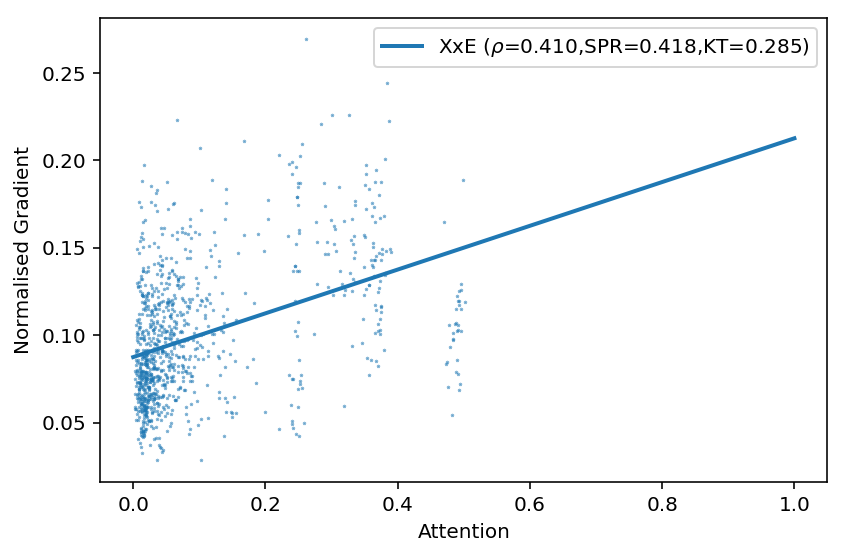

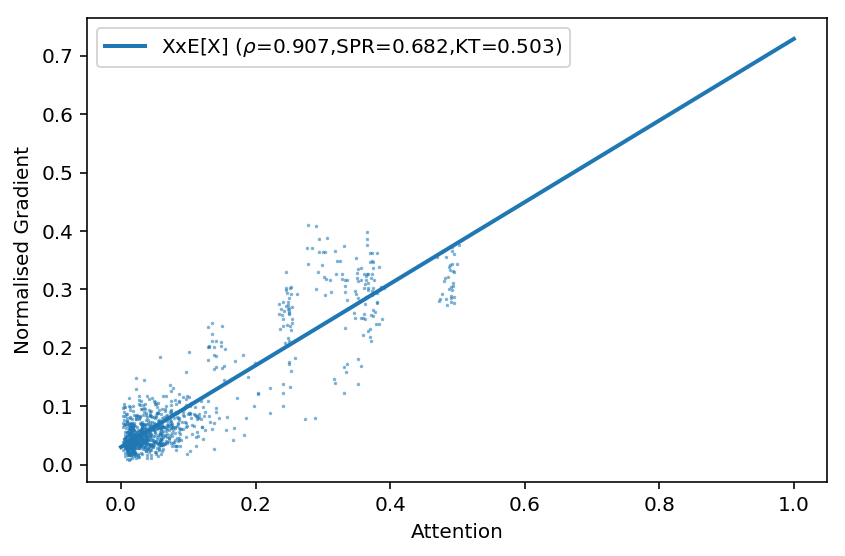

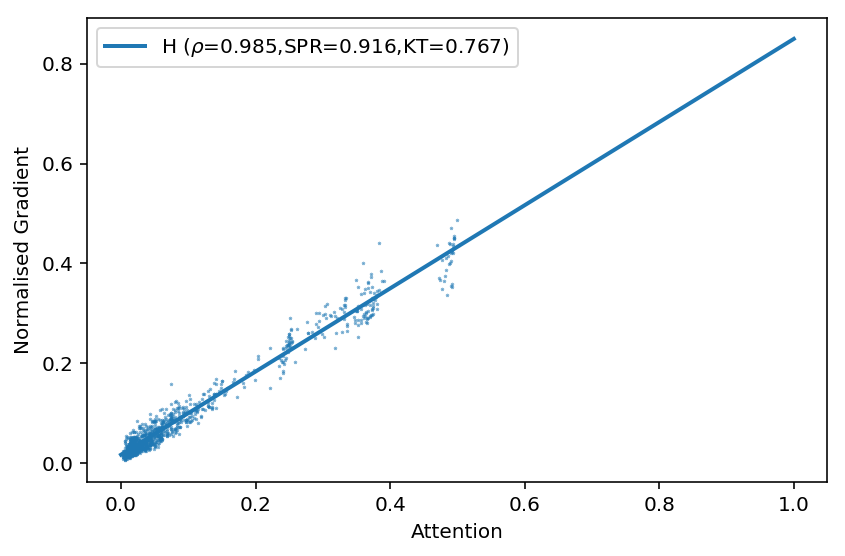

In [20]:
for k in model.sampled :

    calc_corr(model, k)

    plt.rc('lines', linewidth=2)
    line_cycle = cycler('linestyle', ['-', '--'])
    color_cycle = cycler('color', ['#1f78b4', '#33a02c'])
    marker_cycle = cycler('marker', ['+', '2'])

    fig, ax = plt.subplots()
    ax.set_prop_cycle(line_cycle + color_cycle) # + marker_cycle)
    plot(model.attn, model.sampled, ax, name=k, marker='*')
    ax.legend()
    plt.tight_layout()
    plt.savefig(k+'.pdf')

Attention Maps
==============

In [21]:
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

def showAttention(fig, ax, input_sentence, model, n):
    attn = model.attn[n]
    grads = [model.sampled[k][n] for k in model.sampled]
    attentions = np.stack([attn] + grads, axis=0)
    
    a1 = attentions
    img = ax.imshow(a1, cmap='PuRd', vmin=0, vmax=1, interpolation='none')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.05)
    fig.colorbar(img, cax=cax, ax=ax)
    
    # Set up axes
    ax.set_xticks(np.arange(len(input_sentence)))
    ax.set_xticklabels(input_sentence, rotation=85)
    
    ax.set_yticks(np.arange(len(model.sampled)+1))
    ax.set_yticklabels(['attention'] + list(model.sampled.keys()))

/home/sarthak/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


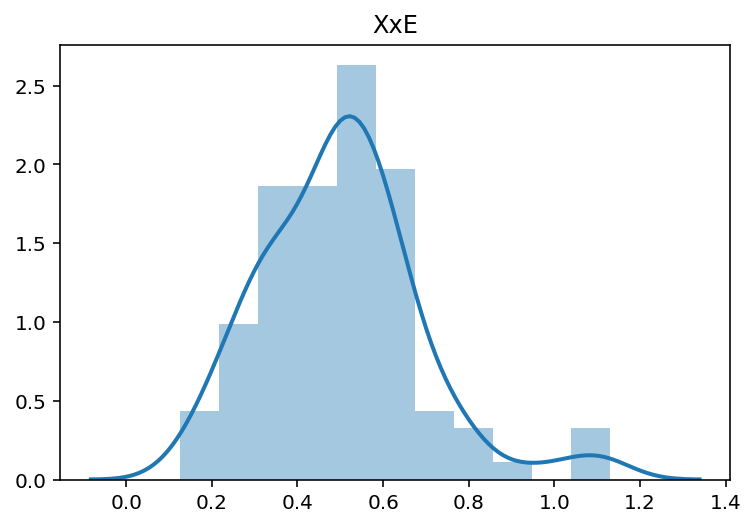

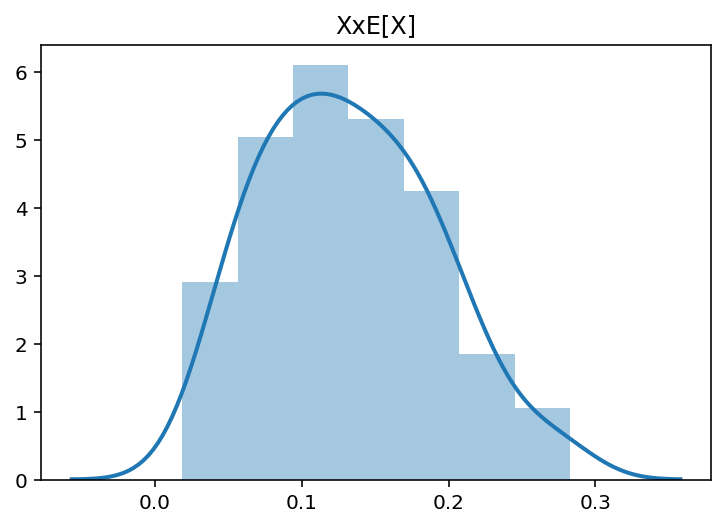

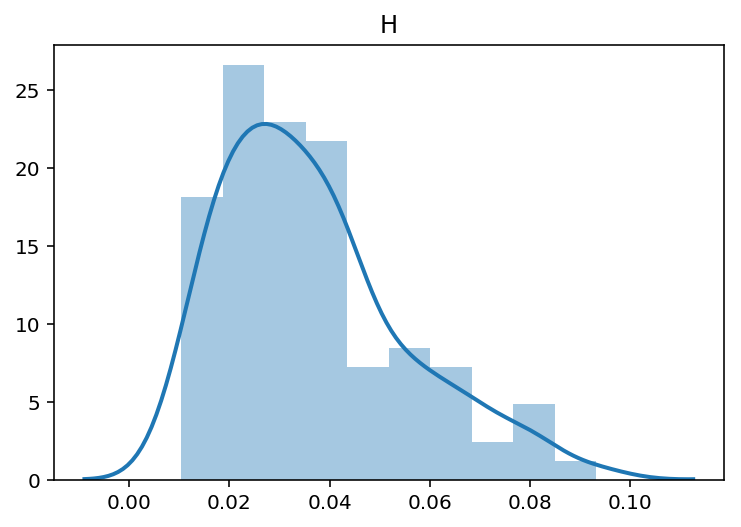

In [22]:
for k in model_normal_list[exps[0]].sampled : 
    sns.distplot(model.diff[k])
    plt.title(k)
    plt.show()

In [23]:
idxs = np.random.choice(range(len(Xtest)), size=10)

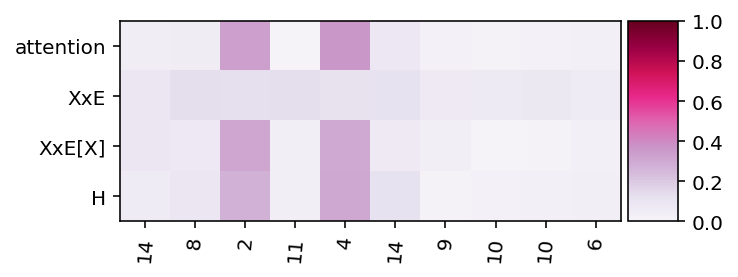

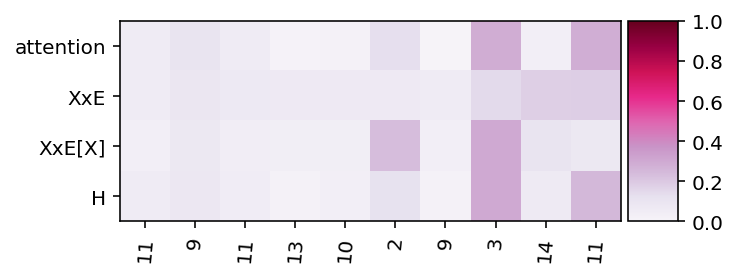

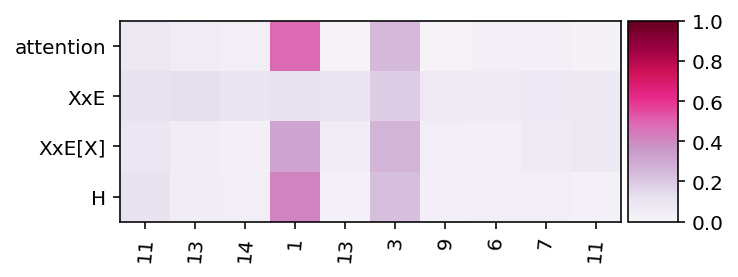

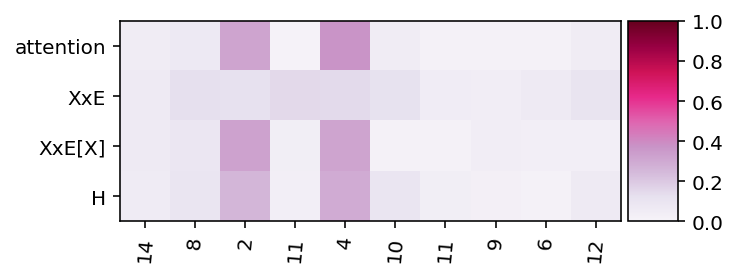

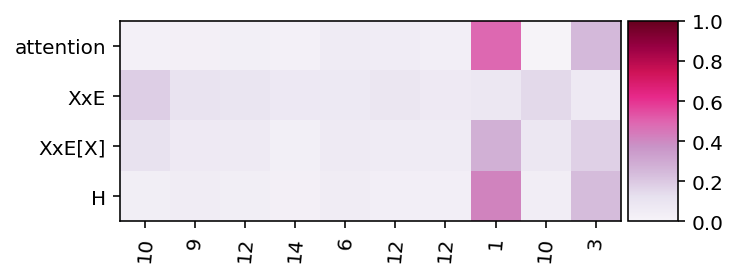

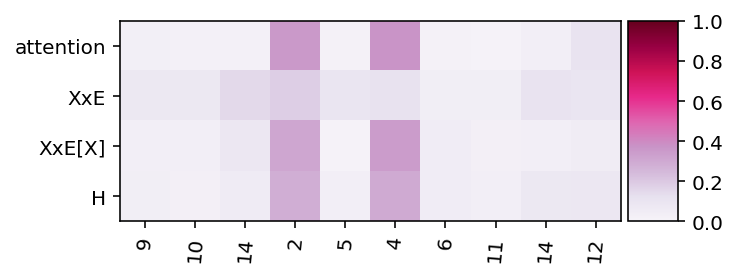

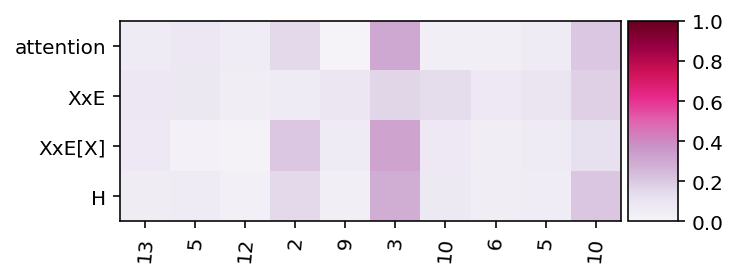

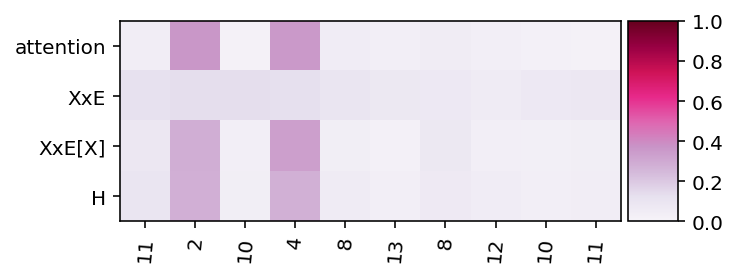

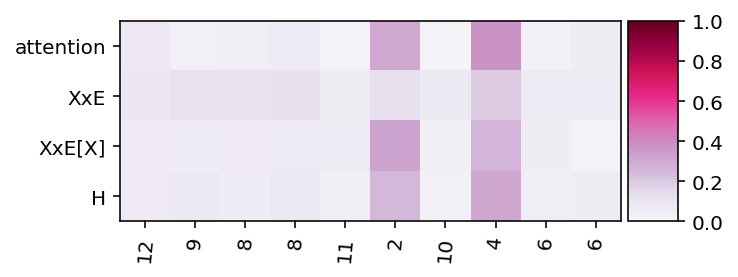

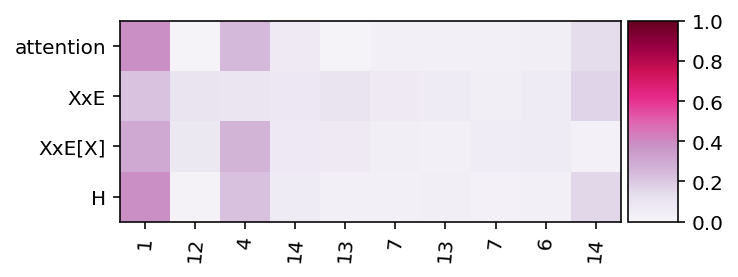

In [24]:
for n in idxs[:10] :
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 50))
    showAttention(fig, axes, [vec.idx2word[x] for x in Xtest[n]], model, n)

In [25]:
word_score = {}
word_freq = {}
word_grad = {k:{} for k in model.sampled}
for i in range(len(Xtest)) :
    words = Xtest[i][1:-1]
    attn_word = model.attn[i]
    for j in range(len(words)) :
        if words[j] in word_score :
            word_score[words[j]] += attn_word[j]
            word_freq[words[j]] += 1
            for k in model.sampled :
                word_grad[k][words[j]] += model.sampled[k][i][j]
        else :
            word_score[words[j]] = attn_word[j]
            word_freq[words[j]] = 1
            for k in model.sampled :
                word_grad[k][words[j]] = model.sampled[k][i][j]

In [26]:
word_map_score = {vec.idx2word[k]:v/word_freq[k] for k, v in word_score.items()}
word_map_grad = {s:{vec.idx2word[k]:v/word_freq[k] for k, v in word_grad[s].items()} for s in word_grad}

In [27]:
import operator
top100attn = sorted(word_map_score.items(), key=operator.itemgetter(1), reverse=True)[:5]
top100attn = set([x[0] for x in top100attn])
for k in model.sampled :
    top100grad = sorted(word_map_grad[k].items(), key=operator.itemgetter(1), reverse=True)[:5]
    top100grad = set([x[0] for x in top100grad])
    print(k, len(top100attn & top100grad))
    print(top100attn - top100grad)
    print(top100grad - top100attn)
    print(top100attn & top100grad)

XxE 2
{'5', '13', '10'}
{'6', '4', '8'}
{'14', '11'}
XxE[X] 5
set()
set()
{'5', '10', '14', '11', '13'}
H 5
set()
set()
{'5', '10', '14', '11', '13'}
